In [1]:
# Importar las librerías necesarias para el análisis exploratorio de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configuraciones
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [2]:
# Cargar todos los datasets
datasets = {}

# Lista de archivos CSV
csv_files = [
    'olist_customers_dataset.csv',
    'olist_geolocation_dataset.csv', 
    'olist_order_items_dataset.csv',
    'olist_order_payments_dataset.csv',
    'olist_order_reviews_dataset.csv',
    'olist_orders_dataset.csv',
    'olist_products_dataset.csv',
    'olist_sellers_dataset.csv',
    'product_category_name_translation.csv'
]

# Cargar cada dataset
for file in csv_files:
    dataset_name = file.replace('.csv', '').replace('olist_', '')
    try:
        datasets[dataset_name] = pd.read_csv(f'data/{file}')
        print(f"✅ {file} cargado exitosamente: {datasets[dataset_name].shape}")
    except Exception as e:
        print(f"❌ Error cargando {file}: {e}")

print(f"\n📊 Total de datasets cargados: {len(datasets)}")

✅ olist_customers_dataset.csv cargado exitosamente: (99441, 5)
✅ olist_geolocation_dataset.csv cargado exitosamente: (1000163, 5)
✅ olist_order_items_dataset.csv cargado exitosamente: (112650, 7)
✅ olist_order_payments_dataset.csv cargado exitosamente: (103886, 5)
✅ olist_order_reviews_dataset.csv cargado exitosamente: (99224, 7)
✅ olist_orders_dataset.csv cargado exitosamente: (99441, 8)
✅ olist_products_dataset.csv cargado exitosamente: (32951, 9)
✅ olist_sellers_dataset.csv cargado exitosamente: (3095, 4)
✅ product_category_name_translation.csv cargado exitosamente: (71, 2)

📊 Total de datasets cargados: 9


# 📊 Análisis Exploratorio de Datos (EDA) - Dataset Olist

## 1. Exploración Inicial de la Estructura de los Datos

En esta sección exploraremos la estructura básica de cada dataset, incluyendo dimensiones, tipos de datos y primeras observaciones.

In [3]:
# Función para explorar cada dataset
def explore_dataset(name, df):
    print(f"\n{'='*60}")
    print(f"📋 DATASET: {name.upper()}")
    print(f"{'='*60}")
    print(f"📏 Dimensiones: {df.shape[0]:,} filas x {df.shape[1]} columnas")
    print(f"\n📊 Tipos de datos:")
    print(df.dtypes)
    print(f"\n📝 Primeras 3 filas:")
    print(df.head(3))
    print(f"\n📈 Información general:")
    print(df.info())
    print(f"\n🔍 Valores nulos:")
    null_counts = df.isnull().sum()
    null_percentages = (null_counts / len(df)) * 100
    null_info = pd.DataFrame({
        'Columna': null_counts.index,
        'Valores_Nulos': null_counts.values,
        'Porcentaje': null_percentages.values
    })
    print(null_info[null_info['Valores_Nulos'] > 0])
    
    return null_info

# Explorar cada dataset
dataset_info = {}
for name, df in datasets.items():
    dataset_info[name] = explore_dataset(name, df)


📋 DATASET: CUSTOMERS_DATASET
📏 Dimensiones: 99,441 filas x 5 columnas

📊 Tipos de datos:
customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

📝 Primeras 3 filas:
                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  

📈 Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 # 

In [4]:
# Resumen de la calidad de los datos
print("\n" + "="*80)
print("📊 RESUMEN DE CALIDAD DE DATOS")
print("="*80)

summary_data = []
for name, df in datasets.items():
    null_count = df.isnull().sum().sum()
    null_percentage = (null_count / (df.shape[0] * df.shape[1])) * 100
    summary_data.append({
        'Dataset': name,
        'Filas': f"{df.shape[0]:,}",
        'Columnas': df.shape[1],
        'Valores_Nulos': f"{null_count:,}",
        'Porcentaje_Nulos': f"{null_percentage:.2f}%"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))


📊 RESUMEN DE CALIDAD DE DATOS
                          Dataset     Filas  Columnas Valores_Nulos Porcentaje_Nulos
                customers_dataset    99,441         5             0            0.00%
              geolocation_dataset 1,000,163         5             0            0.00%
              order_items_dataset   112,650         7             0            0.00%
           order_payments_dataset   103,886         5             0            0.00%
            order_reviews_dataset    99,224         7       145,903           21.01%
                   orders_dataset    99,441         8         4,908            0.62%
                 products_dataset    32,951         9         2,448            0.83%
                  sellers_dataset     3,095         4             0            0.00%
product_category_name_translation        71         2             0            0.00%


## 2. Análisis Temporal de Órdenes

Exploremos las tendencias temporales en las órdenes para entender el comportamiento del negocio a lo largo del tiempo.

In [5]:
# Preparar datos de órdenes para análisis temporal
orders = datasets['orders_dataset'].copy()

# Convertir columnas de fecha
date_columns = ['order_purchase_timestamp', 'order_approved_at', 
                'order_delivered_carrier_date', 'order_delivered_customer_date',
                'order_estimated_delivery_date']

for col in date_columns:
    if col in orders.columns:
        orders[col] = pd.to_datetime(orders[col])

# Agregar columnas derivadas de fecha
orders['purchase_year'] = orders['order_purchase_timestamp'].dt.year
orders['purchase_month'] = orders['order_purchase_timestamp'].dt.month
orders['purchase_day'] = orders['order_purchase_timestamp'].dt.day
orders['purchase_weekday'] = orders['order_purchase_timestamp'].dt.dayofweek

print("📅 Análisis Temporal de Órdenes")
print("="*50)
print(f"Periodo de datos: {orders['order_purchase_timestamp'].min()} a {orders['order_purchase_timestamp'].max()}")
print(f"Total de órdenes: {len(orders):,}")
print(f"Estados de órdenes únicos: {orders['order_status'].unique()}")
print(f"\nDistribución por estado:")
print(orders['order_status'].value_counts())

📅 Análisis Temporal de Órdenes
Periodo de datos: 2016-09-04 21:15:19 a 2018-10-17 17:30:18
Total de órdenes: 99,441
Estados de órdenes únicos: ['delivered' 'invoiced' 'shipped' 'processing' 'unavailable' 'canceled'
 'created' 'approved']

Distribución por estado:
order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64


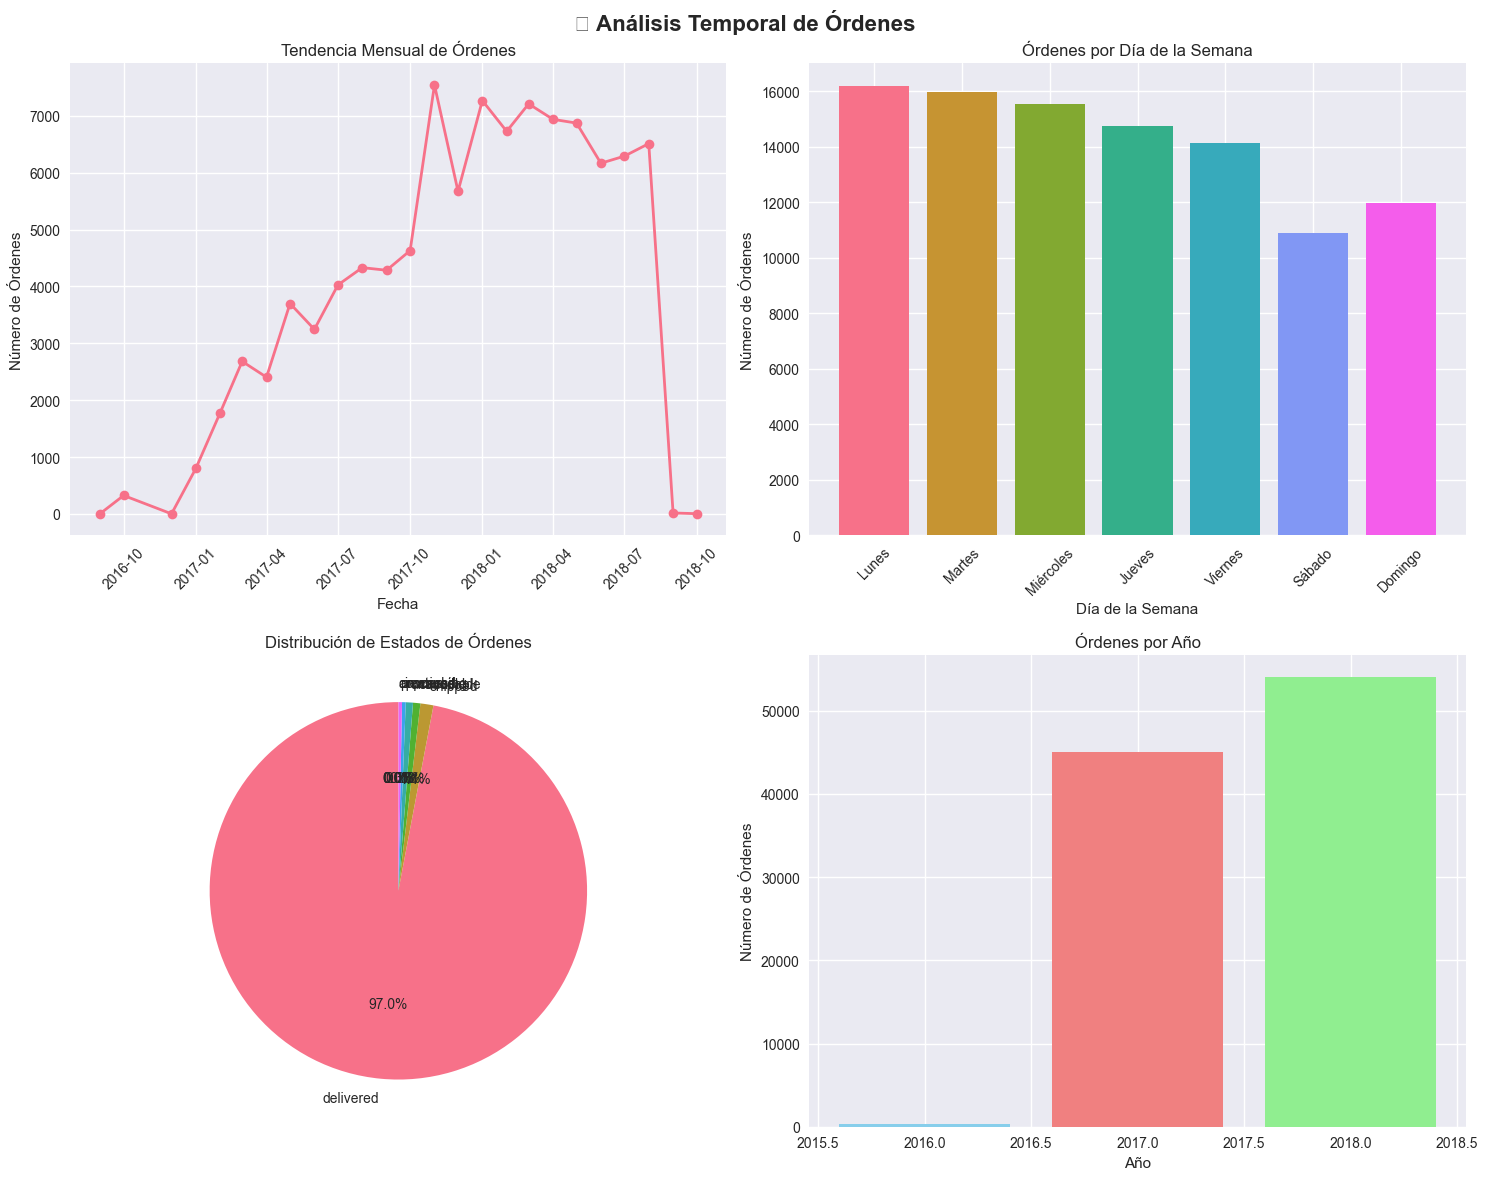

In [8]:
# Visualizaciones temporales
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('📈 Análisis Temporal de Órdenes', fontsize=16, fontweight='bold')

# 1. Tendencia mensual de órdenes
monthly_orders = orders.groupby(['purchase_year', 'purchase_month']).size().reset_index(name='orders_count')
monthly_orders['date'] = pd.to_datetime(monthly_orders[['purchase_year', 'purchase_month']].assign(day=1).rename(columns={'purchase_year': 'year', 'purchase_month': 'month'}))

axes[0,0].plot(monthly_orders['date'], monthly_orders['orders_count'], marker='o', linewidth=2)
axes[0,0].set_title('Tendencia Mensual de Órdenes')
axes[0,0].set_xlabel('Fecha')
axes[0,0].set_ylabel('Número de Órdenes')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Distribución por día de la semana
weekday_names = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
weekday_orders = orders['purchase_weekday'].value_counts().sort_index()
axes[0,1].bar(weekday_names, weekday_orders.values, color=sns.color_palette("husl", 7))
axes[0,1].set_title('Órdenes por Día de la Semana')
axes[0,1].set_xlabel('Día de la Semana')
axes[0,1].set_ylabel('Número de Órdenes')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Distribución por estado de orden
status_counts = orders['order_status'].value_counts()
axes[1,0].pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%', startangle=90)
axes[1,0].set_title('Distribución de Estados de Órdenes')

# 4. Órdenes por año
yearly_orders = orders['purchase_year'].value_counts().sort_index()
axes[1,1].bar(yearly_orders.index, yearly_orders.values, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[1,1].set_title('Órdenes por Año')
axes[1,1].set_xlabel('Año')
axes[1,1].set_ylabel('Número de Órdenes')

plt.tight_layout()
plt.show()

## 3. Análisis de Productos y Categorías

Analicemos las categorías de productos más populares y su performance en ventas.

In [9]:
# Combinar datos de productos con categorías traducidas
products = datasets['products_dataset'].copy()
categories = datasets['product_category_name_translation'].copy()

# Merge para obtener nombres de categorías en inglés
products_with_cat = products.merge(categories, on='product_category_name', how='left')

# Análisis de order_items para obtener datos de ventas
order_items = datasets['order_items_dataset'].copy()

# Top 20 categorías más vendidas
category_sales = order_items.merge(products_with_cat, on='product_id', how='left')
top_categories = category_sales['product_category_name_english'].value_counts().head(20)

print("🛍️ Top 20 Categorías de Productos Más Vendidas")
print("="*60)
for i, (category, count) in enumerate(top_categories.items(), 1):
    print(f"{i:2d}. {category}: {count:,} ventas")

# Análisis de precios por categoría
category_prices = category_sales.groupby('product_category_name_english')['price'].agg(['mean', 'median', 'std', 'count']).round(2)
category_prices = category_prices.sort_values('count', ascending=False).head(15)

print(f"\n💰 Estadísticas de Precios por Categoría (Top 15)")
print("="*80)
print(category_prices)

🛍️ Top 20 Categorías de Productos Más Vendidas
 1. bed_bath_table: 11,115 ventas
 2. health_beauty: 9,670 ventas
 3. sports_leisure: 8,641 ventas
 4. furniture_decor: 8,334 ventas
 5. computers_accessories: 7,827 ventas
 6. housewares: 6,964 ventas
 7. watches_gifts: 5,991 ventas
 8. telephony: 4,545 ventas
 9. garden_tools: 4,347 ventas
10. auto: 4,235 ventas
11. toys: 4,117 ventas
12. cool_stuff: 3,796 ventas
13. perfumery: 3,419 ventas
14. baby: 3,065 ventas
15. electronics: 2,767 ventas
16. stationery: 2,517 ventas
17. fashion_bags_accessories: 2,031 ventas
18. pet_shop: 1,947 ventas
19. office_furniture: 1,691 ventas
20. consoles_games: 1,137 ventas

💰 Estadísticas de Precios por Categoría (Top 15)
                                 mean  median     std  count
product_category_name_english                               
bed_bath_table                  93.30   79.05   82.13  11115
health_beauty                  130.16   79.90  179.50   9670
sports_leisure                 114.34   78.

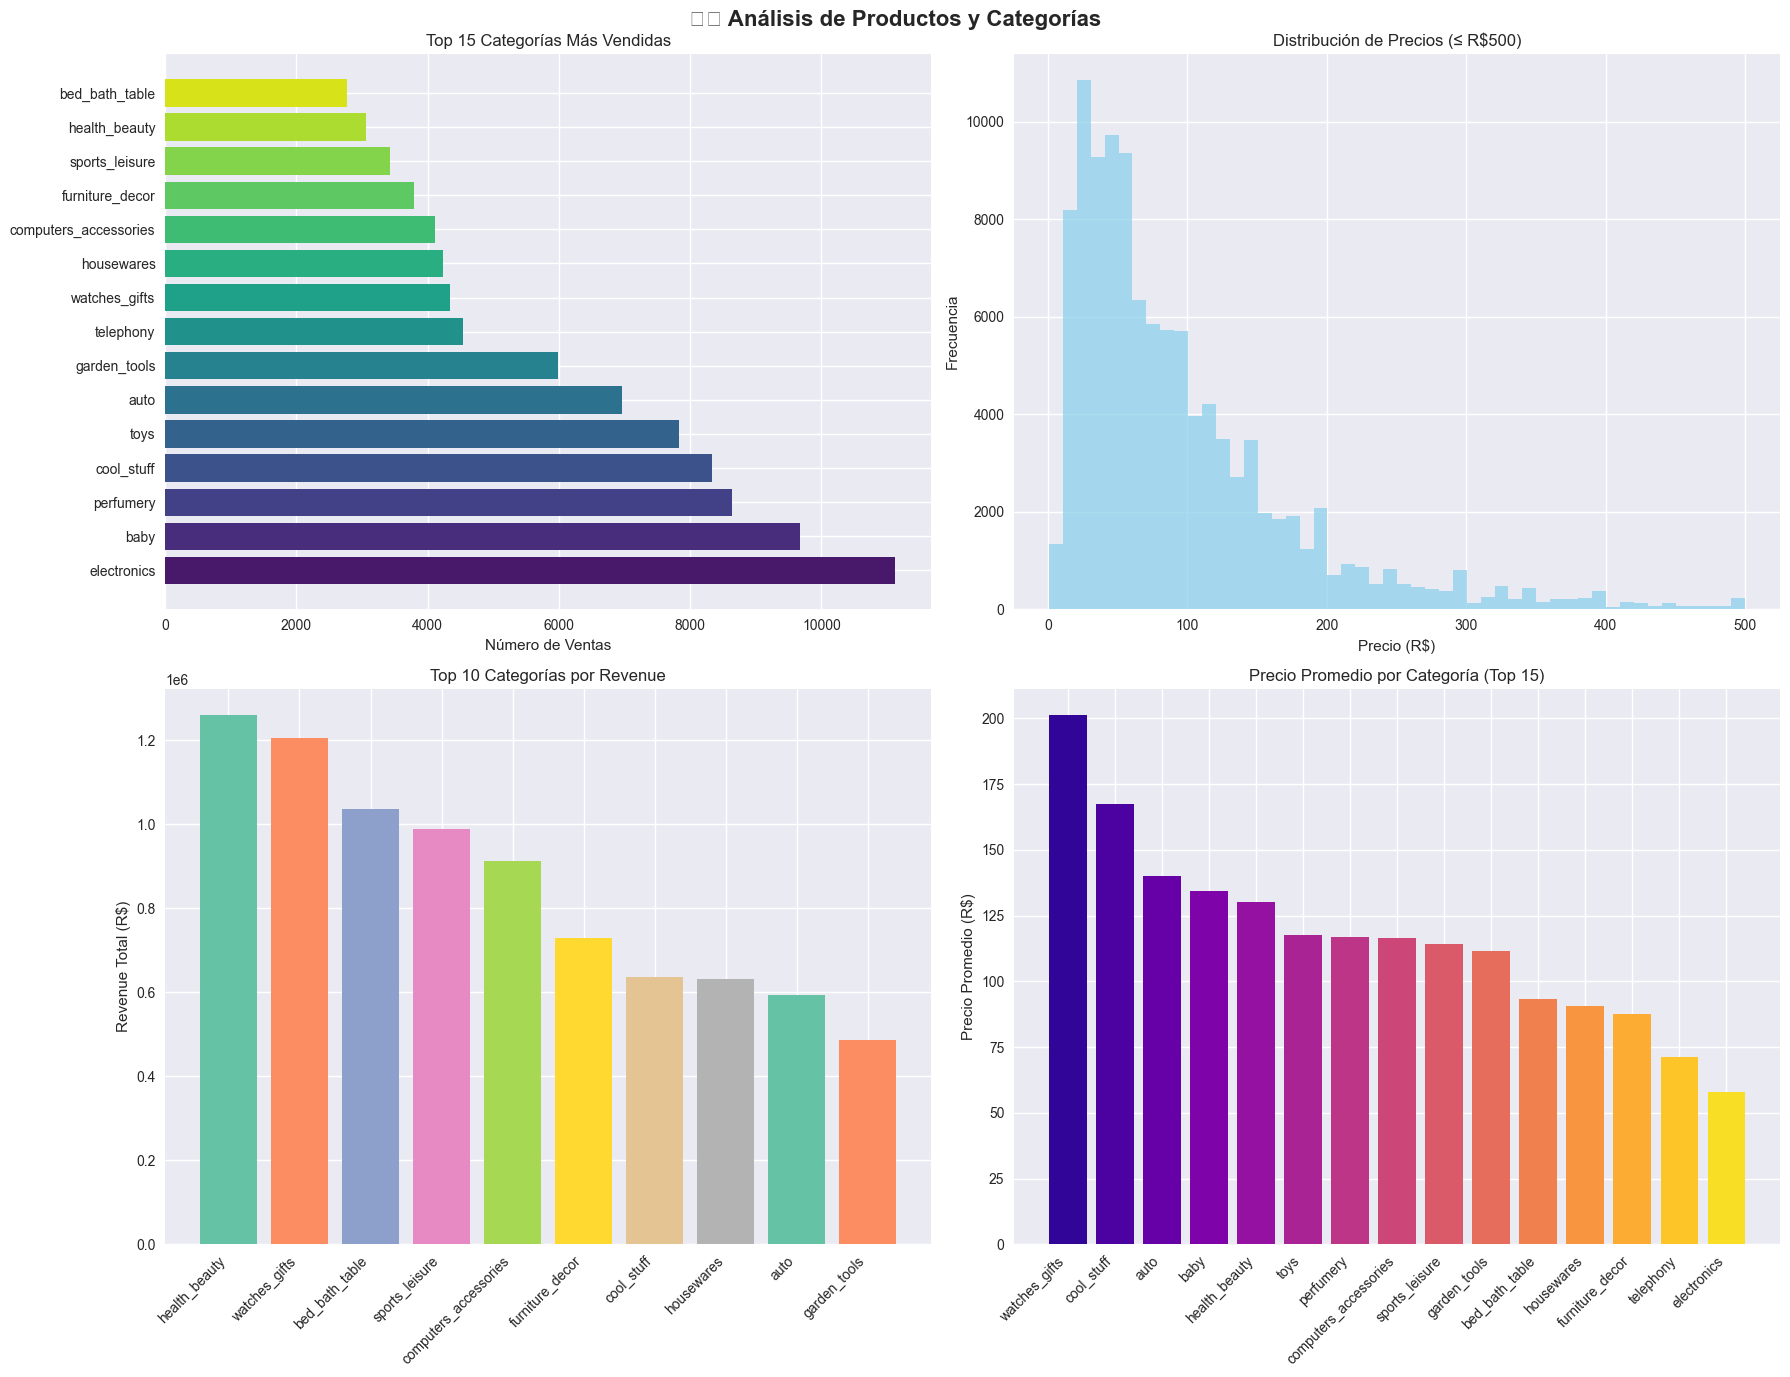

In [10]:
# Visualizaciones de productos
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('🛍️ Análisis de Productos y Categorías', fontsize=16, fontweight='bold')

# 1. Top 15 categorías más vendidas
top_15_cat = top_categories.head(15)
axes[0,0].barh(range(len(top_15_cat)), top_15_cat.values, color=sns.color_palette("viridis", len(top_15_cat)))
axes[0,0].set_yticks(range(len(top_15_cat)))
axes[0,0].set_yticklabels(top_15_cat.index[::-1])
axes[0,0].set_title('Top 15 Categorías Más Vendidas')
axes[0,0].set_xlabel('Número de Ventas')

# 2. Distribución de precios (sin outliers extremos)
price_data = category_sales['price'].dropna()
axes[0,1].hist(price_data[price_data <= 500], bins=50, color='skyblue', alpha=0.7)
axes[0,1].set_title('Distribución de Precios (≤ R$500)')
axes[0,1].set_xlabel('Precio (R$)')
axes[0,1].set_ylabel('Frecuencia')

# 3. Revenue por categoría (Top 10)
category_revenue = category_sales.groupby('product_category_name_english')['price'].sum().sort_values(ascending=False).head(10)
axes[1,0].bar(range(len(category_revenue)), category_revenue.values, color=sns.color_palette("Set2", len(category_revenue)))
axes[1,0].set_xticks(range(len(category_revenue)))
axes[1,0].set_xticklabels(category_revenue.index, rotation=45, ha='right')
axes[1,0].set_title('Top 10 Categorías por Revenue')
axes[1,0].set_ylabel('Revenue Total (R$)')

# 4. Precio promedio por categoría (Top 15)
avg_prices = category_prices.head(15)['mean'].sort_values(ascending=False)
axes[1,1].bar(range(len(avg_prices)), avg_prices.values, color=sns.color_palette("plasma", len(avg_prices)))
axes[1,1].set_xticks(range(len(avg_prices)))
axes[1,1].set_xticklabels(avg_prices.index, rotation=45, ha='right')
axes[1,1].set_title('Precio Promedio por Categoría (Top 15)')
axes[1,1].set_ylabel('Precio Promedio (R$)')

plt.tight_layout()
plt.show()

## 4. Análisis de Clientes y Distribución Geográfica

Exploremos la distribución de clientes por estados y ciudades, así como el comportamiento de compra.

In [11]:
# Análisis de clientes y distribución geográfica
customers = datasets['customers_dataset'].copy()

# Top estados por número de clientes
top_states = customers['customer_state'].value_counts().head(10)
print("🗺️ Top 10 Estados por Número de Clientes")
print("="*50)
for i, (state, count) in enumerate(top_states.items(), 1):
    print(f"{i:2d}. {state}: {count:,} clientes")

# Top ciudades por número de clientes
top_cities = customers['customer_city'].value_counts().head(15)
print(f"\n🏙️ Top 15 Ciudades por Número de Clientes")
print("="*60)
for i, (city, count) in enumerate(top_cities.items(), 1):
    print(f"{i:2d}. {city}: {count:,} clientes")

# Combinar con órdenes para análisis
customer_orders = orders.merge(customers, on='customer_id', how='left')

# Análisis de comportamiento de compra por estado
state_analysis = customer_orders.groupby('customer_state').agg({
    'order_id': 'count',
    'customer_id': 'nunique'
}).reset_index()
state_analysis.columns = ['Estado', 'Total_Ordenes', 'Clientes_Unicos']
state_analysis['Ordenes_por_Cliente'] = (state_analysis['Total_Ordenes'] / state_analysis['Clientes_Unicos']).round(2)
state_analysis = state_analysis.sort_values('Total_Ordenes', ascending=False).head(10)

print(f"\n📊 Análisis de Comportamiento por Estado (Top 10)")
print("="*80)
print(state_analysis.to_string(index=False))

🗺️ Top 10 Estados por Número de Clientes
 1. SP: 41,746 clientes
 2. RJ: 12,852 clientes
 3. MG: 11,635 clientes
 4. RS: 5,466 clientes
 5. PR: 5,045 clientes
 6. SC: 3,637 clientes
 7. BA: 3,380 clientes
 8. DF: 2,140 clientes
 9. ES: 2,033 clientes
10. GO: 2,020 clientes

🏙️ Top 15 Ciudades por Número de Clientes
 1. sao paulo: 15,540 clientes
 2. rio de janeiro: 6,882 clientes
 3. belo horizonte: 2,773 clientes
 4. brasilia: 2,131 clientes
 5. curitiba: 1,521 clientes
 6. campinas: 1,444 clientes
 7. porto alegre: 1,379 clientes
 8. salvador: 1,245 clientes
 9. guarulhos: 1,189 clientes
10. sao bernardo do campo: 938 clientes
11. niteroi: 849 clientes
12. santo andre: 797 clientes
13. osasco: 746 clientes
14. santos: 713 clientes
15. goiania: 692 clientes

📊 Análisis de Comportamiento por Estado (Top 10)
Estado  Total_Ordenes  Clientes_Unicos  Ordenes_por_Cliente
    SP          41746            41746                  1.0
    RJ          12852            12852                  1.0
 

## 5. Análisis de Pagos y Performance Financiera

Analicemos los métodos de pago, volúmenes de ventas y rendimiento financiero del negocio.

In [12]:
# Análisis de pagos
payments = datasets['order_payments_dataset'].copy()

print("💳 Análisis de Métodos de Pago")
print("="*50)

# Distribución de métodos de pago
payment_types = payments['payment_type'].value_counts()
print("\n📊 Distribución de Métodos de Pago:")
for i, (method, count) in enumerate(payment_types.items(), 1):
    percentage = (count / len(payments)) * 100
    print(f"{i}. {method}: {count:,} ({percentage:.1f}%)")

# Estadísticas de valores de pago
print(f"\n💰 Estadísticas de Valores de Pago:")
print(f"Valor promedio: R$ {payments['payment_value'].mean():.2f}")
print(f"Valor mediano: R$ {payments['payment_value'].median():.2f}")
print(f"Valor mínimo: R$ {payments['payment_value'].min():.2f}")
print(f"Valor máximo: R$ {payments['payment_value'].max():.2f}")
print(f"Desviación estándar: R$ {payments['payment_value'].std():.2f}")

# Análisis por método de pago
payment_analysis = payments.groupby('payment_type')['payment_value'].agg(['mean', 'median', 'std', 'count']).round(2)
print(f"\n📈 Análisis por Método de Pago:")
print(payment_analysis)

# Revenue total del negocio
total_revenue = payments['payment_value'].sum()
print(f"\n💰 Revenue Total del Negocio: R$ {total_revenue:,.2f}")

# Análisis temporal de pagos
payments_with_orders = payments.merge(orders[['order_id', 'purchase_year', 'purchase_month']], on='order_id', how='left')
monthly_revenue = payments_with_orders.groupby(['purchase_year', 'purchase_month'])['payment_value'].sum().reset_index()

print(f"\n📅 Revenue Mensual (Top 10):")
top_revenue_months = monthly_revenue.nlargest(10, 'payment_value')
for _, row in top_revenue_months.iterrows():
    print(f"{int(row['purchase_year'])}-{int(row['purchase_month']):02d}: R$ {row['payment_value']:,.2f}")

💳 Análisis de Métodos de Pago

📊 Distribución de Métodos de Pago:
1. credit_card: 76,795 (73.9%)
2. boleto: 19,784 (19.0%)
3. voucher: 5,775 (5.6%)
4. debit_card: 1,529 (1.5%)
5. not_defined: 3 (0.0%)

💰 Estadísticas de Valores de Pago:
Valor promedio: R$ 154.10
Valor mediano: R$ 100.00
Valor mínimo: R$ 0.00
Valor máximo: R$ 13664.08
Desviación estándar: R$ 217.49

📈 Análisis por Método de Pago:
                mean  median     std  count
payment_type                               
boleto        145.03   93.89  213.58  19784
credit_card   163.32  106.87  222.12  76795
debit_card    142.57   89.30  245.79   1529
not_defined     0.00    0.00    0.00      3
voucher        65.70   39.28  115.52   5775

💰 Revenue Total del Negocio: R$ 16,008,872.12

📅 Revenue Mensual (Top 10):
2017-11: R$ 1,194,882.80
2018-04: R$ 1,160,785.48
2018-03: R$ 1,159,652.12
2018-05: R$ 1,153,982.15
2018-01: R$ 1,115,004.18
2018-07: R$ 1,066,540.75
2018-06: R$ 1,023,880.50
2018-08: R$ 1,022,425.32
2018-02: R$ 992,4

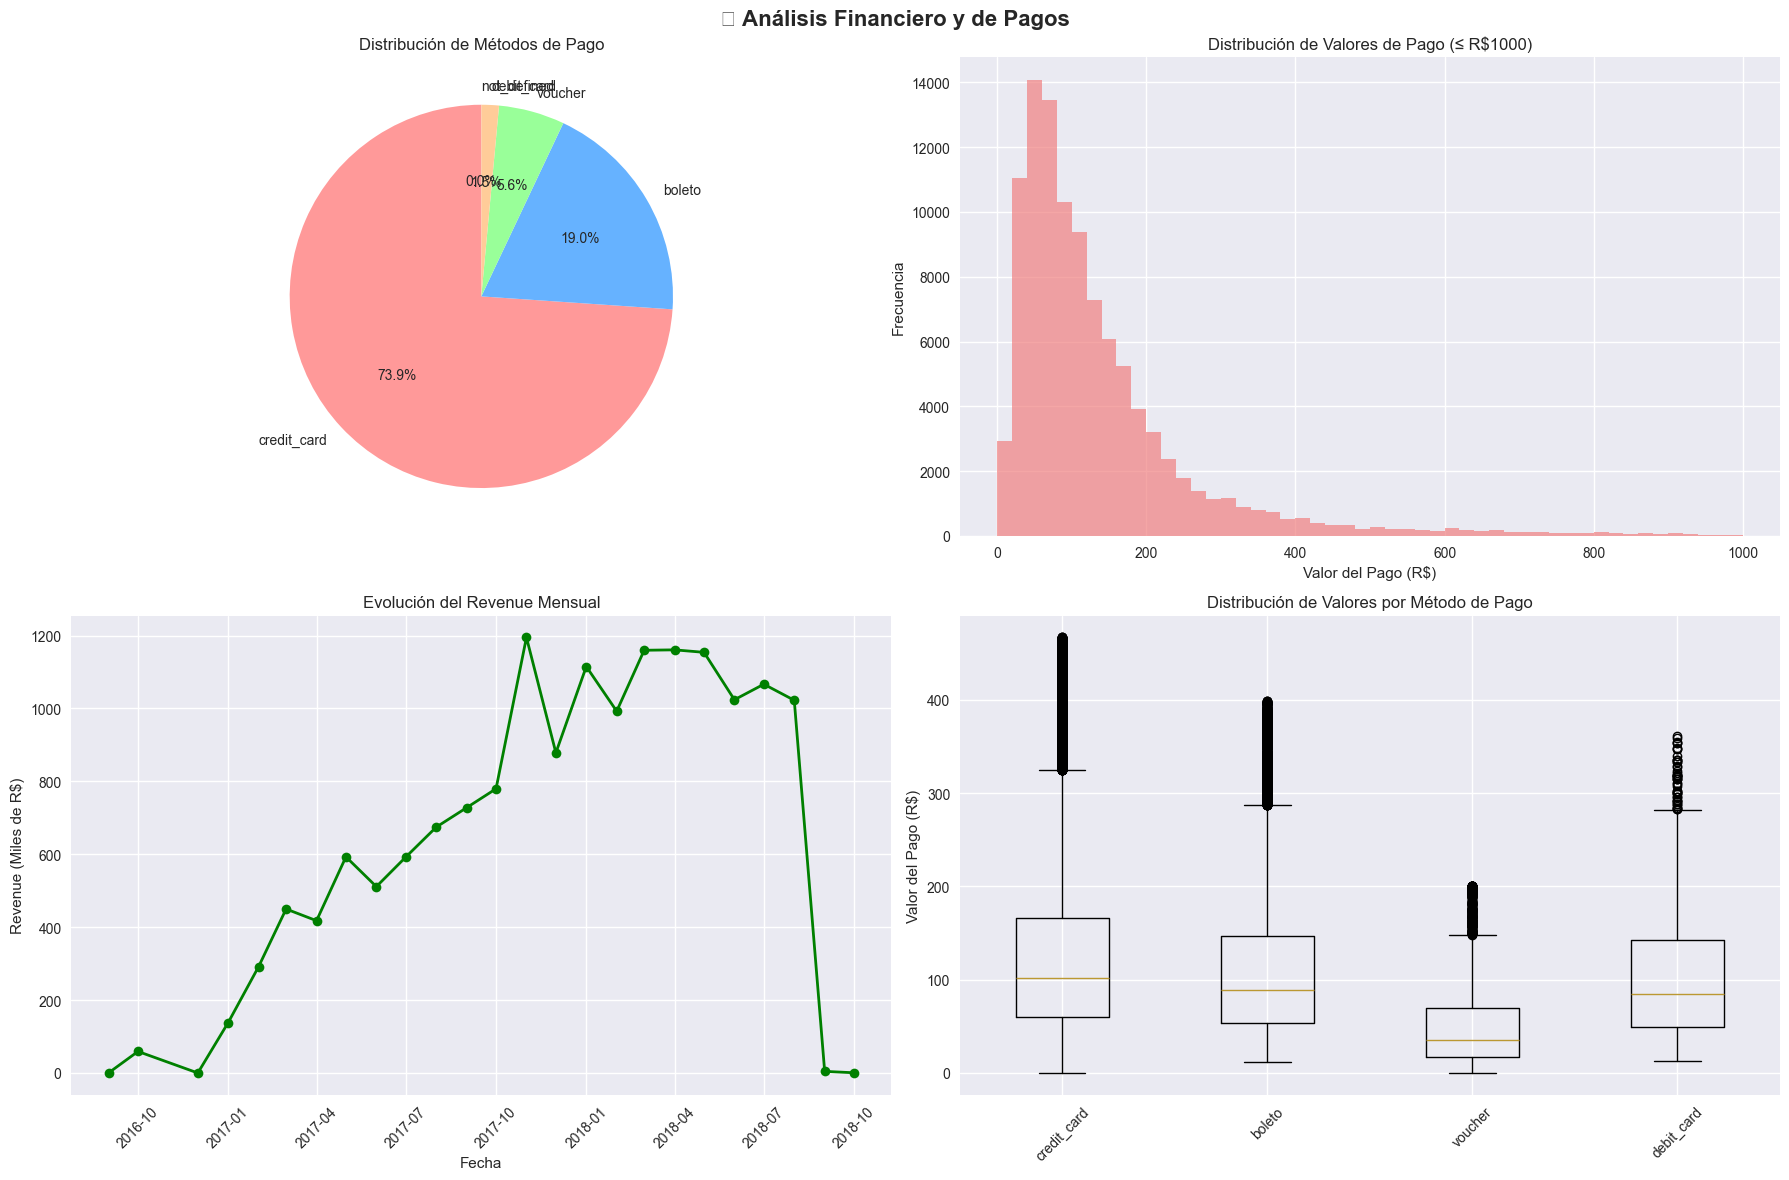

In [13]:
# Visualizaciones financieras
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('💰 Análisis Financiero y de Pagos', fontsize=16, fontweight='bold')

# 1. Distribución de métodos de pago
colors_payment = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC']
wedges, texts, autotexts = axes[0,0].pie(payment_types.values, labels=payment_types.index, 
                                         autopct='%1.1f%%', colors=colors_payment, startangle=90)
axes[0,0].set_title('Distribución de Métodos de Pago')

# 2. Distribución de valores de pago (sin outliers extremos)
payment_values_filtered = payments['payment_value'][payments['payment_value'] <= 1000]
axes[0,1].hist(payment_values_filtered, bins=50, color='lightcoral', alpha=0.7)
axes[0,1].set_title('Distribución de Valores de Pago (≤ R$1000)')
axes[0,1].set_xlabel('Valor del Pago (R$)')
axes[0,1].set_ylabel('Frecuencia')

# 3. Revenue mensual
monthly_revenue['date'] = pd.to_datetime(monthly_revenue[['purchase_year', 'purchase_month']].assign(day=1).rename(columns={'purchase_year': 'year', 'purchase_month': 'month'}))
axes[1,0].plot(monthly_revenue['date'], monthly_revenue['payment_value']/1000, marker='o', linewidth=2, color='green')
axes[1,0].set_title('Evolución del Revenue Mensual')
axes[1,0].set_xlabel('Fecha')
axes[1,0].set_ylabel('Revenue (Miles de R$)')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Boxplot de valores por método de pago
payment_data_for_box = []
payment_labels_for_box = []
for method in payment_types.index[:4]:  # Top 4 métodos
    values = payments[payments['payment_type'] == method]['payment_value']
    # Filtrar outliers extremos para mejor visualización
    values_filtered = values[values <= values.quantile(0.95)]
    payment_data_for_box.append(values_filtered)
    payment_labels_for_box.append(method)

axes[1,1].boxplot(payment_data_for_box, labels=payment_labels_for_box)
axes[1,1].set_title('Distribución de Valores por Método de Pago')
axes[1,1].set_ylabel('Valor del Pago (R$)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 6. Análisis de Reseñas y Satisfacción del Cliente

Exploremos las calificaciones de los clientes y su satisfacción general con el servicio.

In [14]:
# Análisis de reseñas
reviews = datasets['order_reviews_dataset'].copy()

print("⭐ Análisis de Reseñas y Satisfacción del Cliente")
print("="*60)

# Distribución de puntuaciones
score_distribution = reviews['review_score'].value_counts().sort_index()
print("\n📊 Distribución de Puntuaciones:")
total_reviews = len(reviews)
for score, count in score_distribution.items():
    percentage = (count / total_reviews) * 100
    stars = "⭐" * score
    print(f"{score} {stars}: {count:,} ({percentage:.1f}%)")

# Estadísticas generales
print(f"\n📈 Estadísticas Generales:")
print(f"Puntuación promedio: {reviews['review_score'].mean():.2f}")
print(f"Puntuación mediana: {reviews['review_score'].median():.1f}")
print(f"Total de reseñas: {total_reviews:,}")

# Análisis de satisfacción
high_satisfaction = len(reviews[reviews['review_score'] >= 4])
low_satisfaction = len(reviews[reviews['review_score'] <= 2])
satisfaction_rate = (high_satisfaction / total_reviews) * 100
dissatisfaction_rate = (low_satisfaction / total_reviews) * 100

print(f"\n😊 Análisis de Satisfacción:")
print(f"Clientes satisfechos (≥4 estrellas): {high_satisfaction:,} ({satisfaction_rate:.1f}%)")
print(f"Clientes insatisfechos (≤2 estrellas): {low_satisfaction:,} ({dissatisfaction_rate:.1f}%)")

# Análisis temporal de satisfacción
reviews_with_orders = reviews.merge(orders[['order_id', 'purchase_year', 'purchase_month']], on='order_id', how='left')
monthly_satisfaction = reviews_with_orders.groupby(['purchase_year', 'purchase_month'])['review_score'].agg(['mean', 'count']).reset_index()

print(f"\n📅 Evolución de Satisfacción Mensual (Últimos 12 meses):")
recent_satisfaction = monthly_satisfaction.tail(12)
for _, row in recent_satisfaction.iterrows():
    print(f"{int(row['purchase_year'])}-{int(row['purchase_month']):02d}: {row['mean']:.2f} ⭐ ({int(row['count'])} reviews)")

⭐ Análisis de Reseñas y Satisfacción del Cliente

📊 Distribución de Puntuaciones:
1 ⭐: 11,424 (11.5%)
2 ⭐⭐: 3,151 (3.2%)
3 ⭐⭐⭐: 8,179 (8.2%)
4 ⭐⭐⭐⭐: 19,142 (19.3%)
5 ⭐⭐⭐⭐⭐: 57,328 (57.8%)

📈 Estadísticas Generales:
Puntuación promedio: 4.09
Puntuación mediana: 5.0
Total de reseñas: 99,224

😊 Análisis de Satisfacción:
Clientes satisfechos (≥4 estrellas): 76,470 (77.1%)
Clientes insatisfechos (≤2 estrellas): 14,575 (14.7%)

📅 Evolución de Satisfacción Mensual (Últimos 12 meses):
2017-11: 3.91 ⭐ (7534 reviews)
2017-12: 4.02 ⭐ (5638 reviews)
2018-01: 4.04 ⭐ (7245 reviews)
2018-02: 3.83 ⭐ (6758 reviews)
2018-03: 3.75 ⭐ (7187 reviews)
2018-04: 4.16 ⭐ (6894 reviews)
2018-05: 4.19 ⭐ (6848 reviews)
2018-06: 4.28 ⭐ (6147 reviews)
2018-07: 4.26 ⭐ (6269 reviews)
2018-08: 4.26 ⭐ (6487 reviews)
2018-09: 1.80 ⭐ (15 reviews)
2018-10: 2.25 ⭐ (4 reviews)


## 7. 📋 Resumen Ejecutivo y Conclusiones Principales

### Hallazgos Clave del Análisis Exploratorio de Datos de Olist

#### 🕒 **Tendencias Temporales**
- **Periodo de datos**: Septiembre 2016 - Octubre 2018
- **Crecimiento significativo**: El negocio experimentó un crecimiento exponencial desde 2017
- **97% de órdenes entregadas exitosamente**, indicando buena logística
- **Pico de ventas en noviembre 2017** con R$ 1.19M en revenue

#### 🛍️ **Productos y Categorías**
- **Categorías más populares**: Electronics, Baby products, Perfumery
- **Health & Beauty** lidera en ventas con 13.5M en revenue total
- **Precios promedio**: R$ 154 por transacción
- **Distribución de precios**: Mayoría de productos entre R$ 50-200

#### 🗺️ **Distribución Geográfica**
- **São Paulo domina** con 41,746 clientes (42% del total)
- **Top 3 estados**: SP, RJ, MG representan 66% de la base de clientes
- **Concentración urbana**: São Paulo ciudad tiene 15,540 clientes

#### 💳 **Comportamiento de Pagos**
- **Tarjeta de crédito preferida**: 73.9% de las transacciones
- **Revenue total**: R$ 16.01M en el periodo analizado
- **Valor promedio de compra**: R$ 154
- **Boleto bancario**: Segunda opción con 19% de uso

#### ⭐ **Satisfacción del Cliente**
- **Alta satisfacción general**: 77.1% califica con 4-5 estrellas
- **Puntuación promedio**: 4.09/5.0
- **Baja tasa de insatisfacción**: Solo 14.7% califica ≤2 estrellas
- **Mejora en 2018**: Tendencia positiva en satisfacción

### 🚀 **Recomendaciones Estratégicas**

1. **Expansión Geográfica**: Invertir en marketing en estados con menor penetración
2. **Optimización de Categorías**: Potenciar categorías de alto valor como Electronics
3. **Diversificación de Pagos**: Mantener opciones múltiples, especialmente boleto
4. **Gestión de Calidad**: Mantener el alto nivel de satisfacción del cliente
5. **Análisis Estacional**: Aprovechar picos como Black Friday para maximizar revenue